# **CENG 501 Deep Learning - Term Project**

**Name:** Barış Suğur \\
**ID:** 2099315

## **A Causal View on Robustness of Neural Networks**

This notebook consists of the interpreted implementation of the paper "A Causal View on Robustness of Neural Networks" (ICLR 2020) by Cheng Zhang, Kun Zhang and Yingzhen Li. This notebook is structed with the aim of clarifying the general aim of the paper (as best as I could) and explaining the different test stages and robustness comparisons between them. Hence it consists four sections which are: \\


**1.**   Brief Summary of the Paper \\
**2.**   Dataset Selection and Preperation \\
**3.**   FCN Training(s) with Augmented Data \\
**4.**   Proposed Network  \\

## **1. Brief Summary Of The Paper**

The paper presents a casual view relating the robustness of networks against different and unseen input manipulations which applies to classification tasks and general measurement data. Based on this, a new model called deep casual manipulation augmented model (deep CAMA) is proposed that shows superior robustness against unseen manipulations. 

More detailed explanations will be given about the proposed method in section 4. However, because the paper is very abstract on certain aspects of the network (and used parameters), some of the parts will be interpreted. 

For testing the overall robustness of the proposed method, I created three different models that works with same dataset (MNIST). First model is a vanilla FCN that is trained on classic (non-manipulated) data which is tested on randomly manipulated data. This is to show the effect of manipulations that can occur in testing dataset.With the second FCN, we extend the robustness capabilities by adding these randomly generated noisy (or manipulated) inputs to the training dataset. This way we can see the difference data augmentation can make on manipulated inputs and their classifications. Lastly, with the proposed method, similar to second method augmented data will be used for testing data. However since the relation between inputs and their manipulations will be reasoned, we will expect increased performance for unseen manipulations as well.

## **2. Dataset Selection and Preperation**

For the tasks, MNIST dataset is used for numerous reason. Aside of being simple,free and well established, it also is refered number of times in the paper. Also the given manipulation examples like translation and rotation can be easily applied for each input without losing much information and its semantics. The fact that these kind of manipulations occur frequently for handwritten digit inputs makes this the perfect dataset to be worked with.

### Import Python Modules

Load modules into the Python environment.

In [85]:
%matplotlib inline
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers

from keras.datasets import mnist     # MNIST dataset is included in Keras
from keras.models import Sequential  # Model type to be used
from scipy.ndimage.interpolation import shift # For data augmentation

from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils                         # NumPy related tools

### Download the MNIST Dataset

MNIST dataset has 60000 images for training and another 10000 for testing purposes. Fitsr, we will load the dataset and make sure the shapes are correct.

In [86]:
# Download MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Copy training dataset (for augmentation)
XA_train = X_train.copy()
# Print shapes (just to be sure)
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


### Prepare Training and Testing Datasets

Since we will use both classic and manipulated datasets for the tasks, we need to generate two different training datasets with randomly generated manipulations. For simplification, I decided to use only translation with randomized amount and direction. Keep in mind that other manipulations like noise or rotation would work exactly the same way.

In [87]:
translations_train = np.zeros((60000,2))
# FOR TRAINING DATASET
# Select approximately %20 of the training set
train_onehot = np.random.randint(5, size=len(X_train))
# For selected inputs, apply randomized translation (in any direction)
for i in range(len(X_train)):
  if(train_onehot[i] == 1):
    # Create random x,y pair for translation (-8 < x < 8 & -8 < y < 8)
    shifts = np.random.randint(16, size=2) - 8
    # Shift the input according to generated x,y pair
    XA_train[i] = shift(X_train[i], shifts, cval=0)
    translations_train[i] = shifts

In [88]:
translations_test = np.zeros((10000,2))
# FOR TESTING DATASET
# Select approximately %50 of the testing set
test_onehot = np.random.randint(2, size=len(X_test))
# For selected inputs, apply randomized translation (in any direction)
for i in range(len(X_test)):
  if(test_onehot[i] == 1):
    # Create random x,y pair for translation (-10 < x < 10 & -10 < y < 10)
    shifts = np.random.randint(20, size=2) - 10
    # Shift the input according to generated x,y pair, NOTE that X_test is directly changed, since all the testsets are identical
    X_test[i] = shift(X_test[i], shifts, cval=0)
    translations_test[i] = shifts

### View the Manipulated Training Set
Now we can see how our manipulations are effected the input images in the training set below. Roughly half of the images should have some amount of translation embeded in them (since I did not provide a seed, executing the block again will result in different images). Also notice we did not create a seperate testing set like we did in training set because all three implemented networks will use the manipulated dataset for testing.

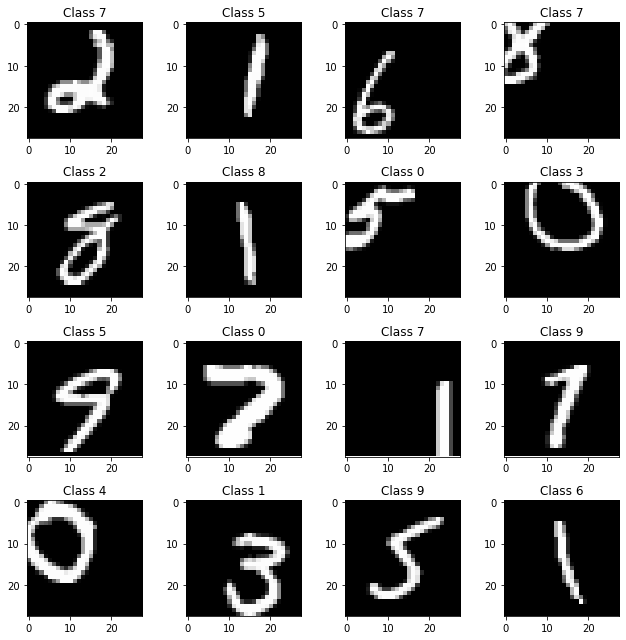

In [89]:
plt.rcParams['figure.figsize'] = (9,9) # Make the figures a bit bigger

# Select random 16 samples from training set
for i in range(16):
    plt.subplot(4,4,i+1)
    num = random.randint(0, len(X_test))
    plt.imshow(X_test[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))
plt.tight_layout()

## **3. FCN Training(s) with Augmented Data**

In this section we will observe two different FCN's results. One without the augmented data training and one with it. Naturally, we expect slightly improved performance from the augmented one. Lets begin;

### Reshape and Normalize Data
We start with flattening the 28 x 28 images into a 1-D vector and apply normalization.

In [90]:
# Reshape datasets
X_train  = X_train.reshape(60000, 784)  
XA_train = XA_train.reshape(60000, 784) 
X_test   = X_test.reshape(10000, 784)   

# Change ints to 32-bit float
X_train  = X_train.astype('float32')    
XA_train = XA_train.astype('float32') 
X_test   = X_test.astype('float32') 

# Apply normalization
X_train  /= 255   
XA_train /= 255
X_test   /= 255 

# Modify the classes to be one-hot format
nb_classes = 10 
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

### Fully Connected Network (FCN)
For the FCN, I choose three layered structure with RELU as its activation function. Softmax is selected as loss function since it is suitible for such an output.

In [91]:
# Sequential model is selected for its simplicity
model = Sequential()
# FIRST LAYER
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))

# SECOND LAYER
model.add(Dense(256))
model.add(Activation('relu'))

# THIRD LAYER (output)
model.add(Dense(10))
model.add(Activation('softmax'))


In [92]:
# View the summary of built model
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 512)               401920    
_________________________________________________________________
activation_27 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_28 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 10)                2570      
_________________________________________________________________
activation_29 (Activation)   (None, 10)                0         
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
________________________________________________

Adam optimizer is selected for faster learning. Adam optimizer extends the stochastic gradient descent by adapting the learning rates according to the moment of update amount, providing a faster approach to the solution.

In [93]:
# Adam optimizer for learning
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Training the First Model
Lets train the first model with non-augmented training data, specifically X_train. 

In [94]:
model.fit(X_train, Y_train, batch_size=128, epochs=5, verbose=1)

Epoch 1/5
469/469 [==============================] - 6s 11ms/step - loss: 0.4319 - accuracy: 0.8732
Epoch 2/5
469/469 [==============================] - 5s 11ms/step - loss: 0.0865 - accuracy: 0.9736
Epoch 3/5
469/469 [==============================] - 5s 11ms/step - loss: 0.0509 - accuracy: 0.9841
Epoch 4/5
469/469 [==============================] - 5s 11ms/step - loss: 0.0331 - accuracy: 0.9898
Epoch 5/5
469/469 [==============================] - 5s 11ms/step - loss: 0.0256 - accuracy: 0.9912


### Testing the First Model
The model produces very high accuracies for training data, but how will it perform for the manipulated test data?

In [95]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 3ms/step - loss: 5.0866 - accuracy: 0.5676
Test score: 5.086638450622559
Test accuracy: 0.5676000118255615


As we can observe, the score and accuracy changes drastically compared to training results. This is expected since the model tested with manipulations it never encountered in its training dataset. Lets compare these results with the second model which we will train with augmented data.

### Training the Second Model
This time, lets train the second model with augmented training data (that is XA_train). 

In [96]:
model.fit(XA_train, Y_train, batch_size=128, epochs=5, verbose=1)

Epoch 1/5
469/469 [==============================] - 5s 11ms/step - loss: 0.2675 - accuracy: 0.9201
Epoch 2/5
469/469 [==============================] - 5s 11ms/step - loss: 0.0951 - accuracy: 0.9697
Epoch 3/5
469/469 [==============================] - 5s 11ms/step - loss: 0.0533 - accuracy: 0.9846
Epoch 4/5
469/469 [==============================] - 5s 11ms/step - loss: 0.0321 - accuracy: 0.9904
Epoch 5/5
469/469 [==============================] - 5s 11ms/step - loss: 0.0229 - accuracy: 0.9935


### Testing the Second Model
Lets test the second model with same augmented test data.

In [97]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.6718 - accuracy: 0.8560
Test score: 0.6717785000801086
Test accuracy: 0.8560000061988831


While the performance when compared to the first model is better, we still miss significant amount of the inputs. This is due to the unseen data in the input. While for each run these would change, we can see the inputs of the augmentedly trained model missed.

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


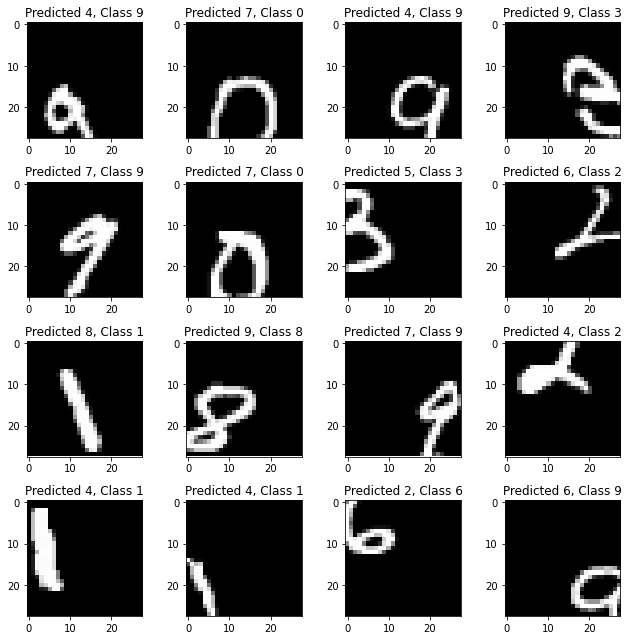

In [98]:
predicted_classes = model.predict_classes(X_test)
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
    
plt.figure()
for i, incorrect in enumerate(incorrect_indices[:16]):
    plt.subplot(4,4,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))
    
plt.tight_layout()

We can see that while some of the inputs are shifted a lot that predicting from them is near impossible, some of them are actually possible to predict. The reason model missed them is because their augmentations are not seen in the training set. With the proposed method, we aim to infer the relation between manipulation and the inputs so that even the unseen changes are predicted.

## **4. Proposed Network**

In this section I tried to implement the proposed network and observe comparison with previous two networks. Howeveri due to the abstract nature of the paper, some steps and details of the network is heavily interpreted by me. Lets start with the main idea of the proposed network.

### Casual Manipulated Augmented Model (CAMA)

Paper proposes a new model that can infer unseen manipulations on the training data and produce correct results for these inputs. In the previous augmentedly trained network, we observed that some of the failed inputs are perfectly recognizible, the reason for failure is that network did not encountered these types of specific manipulated data and could not refer the type of manipulations (in this case translation on x,y axis) to other inputs.

According to the paper, these manipulations on the input data is categorized into three main parts namely Y, M and Z. And end result is calculated with probabilistic model p(X|Y,M,Z). In this context, Y is tthe given input (what digit it is for MNIST), Z is the uninterviened pre-existing manipulations (such as writing style or font) and M is the intervienable manipulations on the input (rotation, tyranslation, noise etc). We are only dealing with M and trying to include p(M|X) to the context of the loss function. This inclusion of X->M is what makes the network learn the unseed manipulations and produce an inference between two concepts.

Proposed network (deep CAMA) introduces a new loss function to be used that involves these manipulations on the network so that model can be adapted to such unseen manipulations. The cause variablez Z, Y and M are converted to feature vectors and combined. Latey they are passed through a network to produce distribution for p(X|Y,M,Z). The new loss function includes mainly two parts. First one is (refering to paper) p(x,y,(do(m=0))) for inputs without any manipulatios (the clear definition for do(m=0) is not given in the paper). Other part is p(x,y,m=m_0) that refers the input manipulations. I tried to interpret these concepts as best as I could while creating the loss function. 

### Prepare Training Data
Here we append M as features to already existant Z and Y training data.

In [100]:
# Append the M manipulation features to the training data (x,y shifts in this case)
XA_train = np.hstack((XA_train,translations_train))
X_test = np.hstack((X_test, translations_test))

### Create Network Model
For fair comparison, we will create exact same network model with previous networks. Only diference will be the input shape (which is 786 instead of 784 since M is added).

In [101]:
# Create same network as pervious FCN's
model2 = Sequential()
# FIRST LAYER
model2.add(Dense(512, input_shape=(786,)))
model2.add(Activation('relu'))

# SECOND LAYER
model2.add(Dense(256))
model2.add(Activation('relu'))

# THIRD LAYER (output)
model2.add(Dense(10))
model2.add(Activation('softmax')) # Should have been different but failed to implement

# Optimizer
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Loss Function
This is the part I have failed to implement. The idea was to weight two different loss functions wrt the tuned lambda parameter to best fit the model. I have tried different interpreted loss functions other than the default softmax() to include the M feature parameters so manpulations would be infered. I believe this is both due to my lack of understanding of the intention for using ELBO (evidence lower bound) and paper's vague abstraction of the functionality of do(m=0) and do(m=m_0). Nevertheless, each loss function I tried performed worse than softmax so I left the overall implementation as it is. Below is one example of the loss function I have tried. 

In [106]:
lmbd = 0.2 # percentage of manipulated data for training
def loss_fn(pred, y, m):
  if (m == 0):
    return lmbd * calc_elbo(pred,y,0)
  else:
    return (1 - lmbd) * (calc_elbo(pred,y,0)) + (lmbd) * (calc_elbo(pred,y,m))

def calc_elbo(pred, y, cond):
  # Calculated ELBO
  # pred: Predicted values
  # cond: represents m_0, if 0, do(m=0)
  return torch.sum(torch.exp(y - pred), 1) + torch.sum((y - pred)**2 / torch.exp(pred), 1)


### Training and Testing

Here we will train and test with same parameters as previous models for fair comparison.

In [102]:
# Train the model
model2.fit(XA_train, Y_train, batch_size=128, epochs=5, verbose=1)

Epoch 1/5
469/469 [==============================] - 6s 11ms/step - loss: 0.7467 - accuracy: 0.7691
Epoch 2/5
469/469 [==============================] - 5s 11ms/step - loss: 0.2024 - accuracy: 0.9379
Epoch 3/5
469/469 [==============================] - 5s 11ms/step - loss: 0.1156 - accuracy: 0.9633
Epoch 4/5
469/469 [==============================] - 5s 11ms/step - loss: 0.0703 - accuracy: 0.9791
Epoch 5/5
469/469 [==============================] - 5s 11ms/step - loss: 0.0514 - accuracy: 0.9835


In [103]:
# Test the model
score = model2.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.6965 - accuracy: 0.8423
Test score: 0.6965129375457764
Test accuracy: 0.8422999978065491


Due to the failed implementation of loss function, this result did not perform any better than the augmentedly trained network. I think with the proper loss function implementation, it would have performed slightly better (mentioned %10-15 higher accuracies depending of inputs). 